# Import libraries and necessary functions

In [5]:
rm(list = ls()); gc();
pacman::p_load(dplyr, glmnet, MASS, ggplot2, yardstick, rpart, rpart.plot, randomForest, e1071, xgboost, gbm, caret, neuralnet, nnet, keras, tidyverse, lightgbm, catboost, ramify, Matrix, MLmetrics)
# library(devtools)
# source_url('https://gist.github.com/fawda123/7471137/raw/cd6e6a0b0bdb4e065c597e52165e5ac887f5fe95/nnet_plot_update.r')
set.seed(20201231)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,806434,43.1,1540011,82.3,1199778,64.1
Vcells,1440338,11.0,8388608,64.0,2246795,17.2


## Accuracy function

In [6]:
accuracy = function(predict, actual){return(mean(predict == actual))} ##計算準確率
f1_score = function(predict, actual){
    recall = sum(actual == 1 & predict == 1)/sum(actual == 1)
    percision = sum(actual == 1 & predict == 1)/sum(predict == 1)
    return(2 * (percision * recall)/(percision + recall))
}

## Metrics report

In [7]:
report = function(predict, actual, titles = 'confusion'){
  recall = sensitivity  = sum(actual == 1 & predict == 1)/sum(actual == 1)
  specifity = sum(actual == 0 & predict == 0)/sum(actual == 0)
  percision = sum(actual == 1 & predict == 1)/sum(predict == 1)
  f1_score = 2 * (percision * recall)/(percision + recall)
  print(titles)
  print(table(predict, actual))
  cat("Accuracy: ", accuracy(predict, actual),"F1 Score: ", f1_score, "\n")
  cat("Sensitivity: ", sensitivity, "Specifity: ",  specifity, "\n")
  combine_data = data.frame(
    prediction = as.factor(predict), 
    real = as.factor(actual))
  cm = conf_mat(data = combine_data, real, prediction)
  autoplot(cm, type = "heatmap", title = titles) +
    theme(legend.position = "right")
}

## Voting

In [8]:
vote <- function(prediction_matrix, weights){
    a = as.matrix(prediction_matrix)
    b = matrix(weights, ncol = 1)
    score = (a*2-1) %*% b
    final_prediction = as.integer(score>=0)
    return(final_prediction)
}

# Import data and preprocess

In [9]:
BankChurners = read.csv("../input/credit-card-customers/BankChurners.csv")
AnalysisData = BankChurners[, -1]
N = NROW(AnalysisData)
trainIndex = sample(N, round(0.7*N), replace = FALSE)
testIndex  = -trainIndex

In [10]:
AnalysisData = AnalysisData[,-c(21, 22)]
FactCol = c('Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category')
AnalysisData[, FactCol] = lapply(AnalysisData[, FactCol], factor)
Attrition_Flag = AnalysisData$Attrition_Flag
Attrition_Flag = factor(ifelse(Attrition_Flag == 'Attrited Customer', 1, 0))
AnalysisData = model.matrix(Attrition_Flag ~., data = AnalysisData)[, -1]
AnalysisData = data.frame(Attrition_Flag = Attrition_Flag, AnalysisData)

trainData = AnalysisData[trainIndex, ]
testData  = AnalysisData[testIndex , ]

prediction_matrix = as.data.frame(AnalysisData$Attrition_Flag[testIndex])

In [11]:
train_X = model.matrix(Attrition_Flag ~., data = trainData)[, -1]
train_Y = trainData$Attrition_Flag
test_X = model.matrix(Attrition_Flag ~., data = testData)[, -1]
test_Y = testData$Attrition_Flag

# Building models (Original)

## LightGBM

In [12]:
# dtrain = lgb.Dataset(data = train_X, label = train_Y)
# params <- list(objective = "multiclass", metric = "multi_error", num_class = 2)
# model <- lgb.train(params = params,
#                    data = dtrain,
#                    nrounds = 100,
#                    min_data = 1,
#                    learning_rate = 1,
#                    verbose = -1)
# LGBM_prediction = argmax(predict(model, test_X, reshape = TRUE))-1
# prediction_matrix['LightGBM'] = LGBM_prediction
# report(LGBM_prediction, test_Y, "LightGBM")

## Logistic Regression

[1] "Logistic regression + LASSO"
       actual
predict    0    1
      0 2430  197
      1  117  294
Accuracy:  0.8966425 F1 Score:  0.6518847 
Sensitivity:  0.598778 Specifity:  0.9540636 


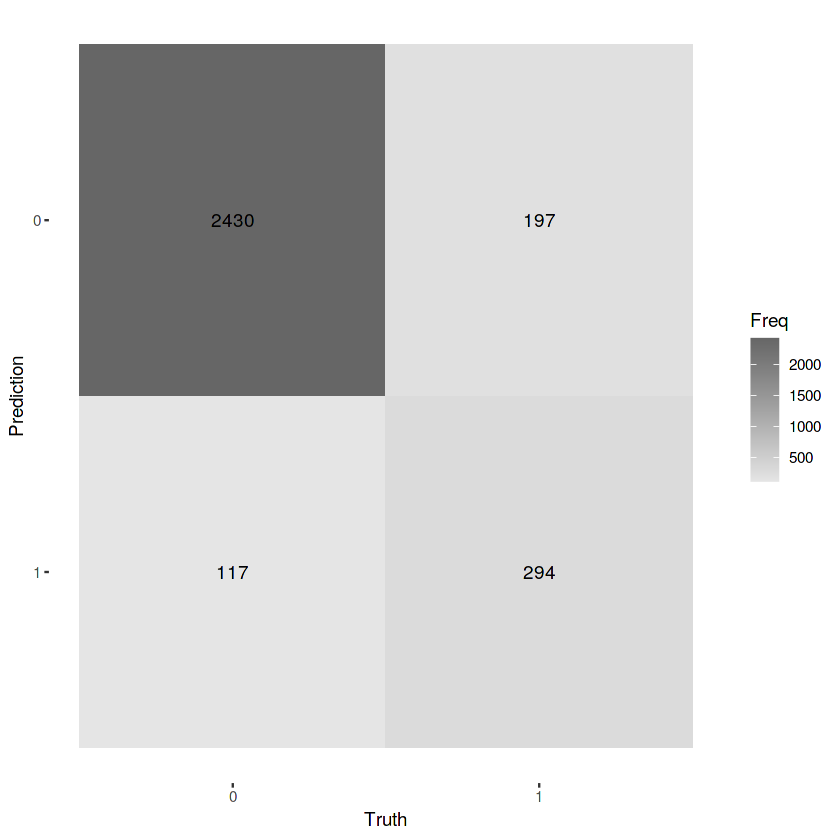

In [13]:
LASSO.cv.fit = cv.glmnet(
  x = train_X,
  y = train_Y,
  alpha = 1, 
  nfolds = 10,
  family = "binomial"
)
logistic_pred_y = predict(LASSO.cv.fit, s = "lambda.min", newx = test_X, type = 'class')
report(logistic_pred_y, test_Y, 'Logistic regression + LASSO')
prediction_matrix['logistic'] = logistic_pred_y

## Decision tree

[1] "Decision Tree"
       actual
predict    0    1
      0 2450  115
      1   97  376
Accuracy:  0.9302172 F1 Score:  0.780083 
Sensitivity:  0.7657841 Specifity:  0.961916 


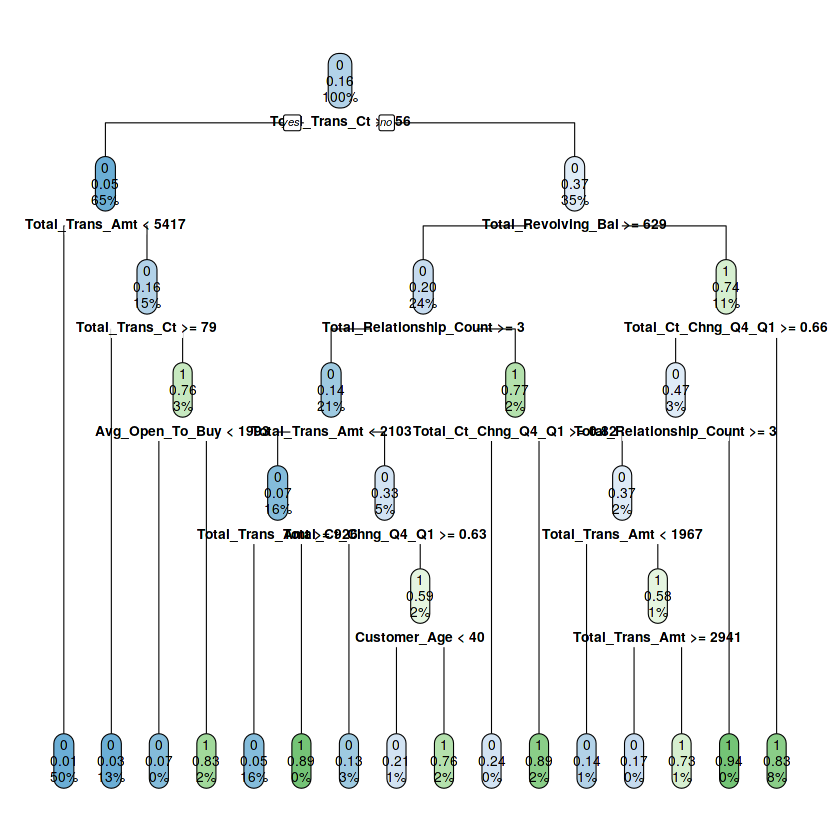

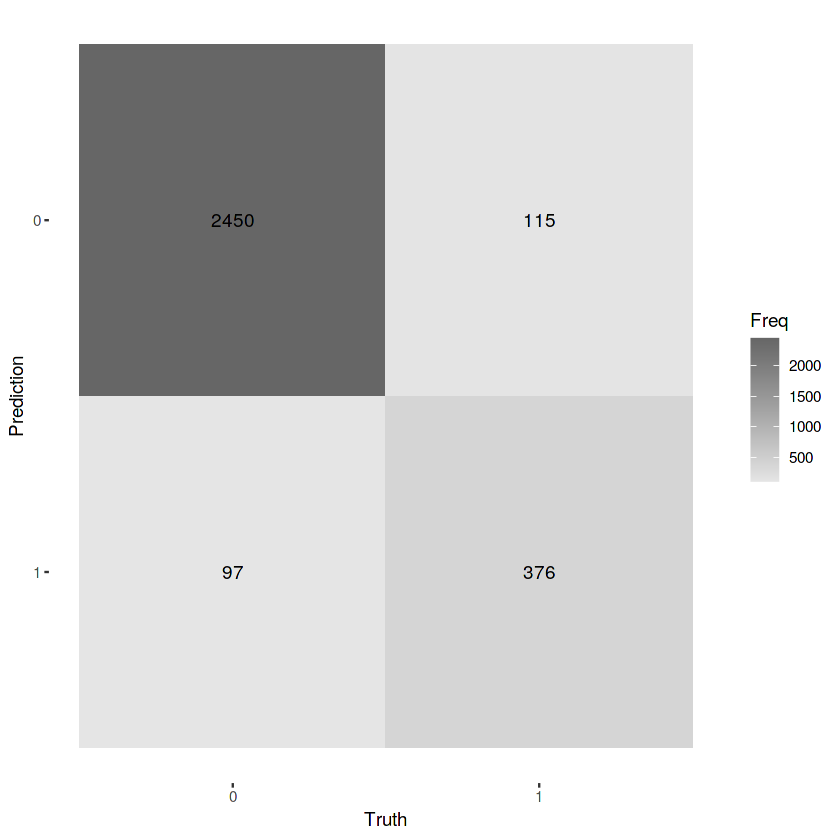

In [14]:
dt_model = rpart(Attrition_Flag ~ .,data = trainData, method = "class")
rpart.plot(dt_model)
dt_prediction = predict(dt_model, testData, type = 'class')
report(dt_prediction, test_Y, 'Decision Tree')
prediction_matrix['DT'] = dt_prediction

## Random Forest

[1] "Random Forest"
       actual
predict    0    1
      0 2514  102
      1   33  389
Accuracy:  0.9555629 F1 Score:  0.8521358 
Sensitivity:  0.7922607 Specifity:  0.9870436 


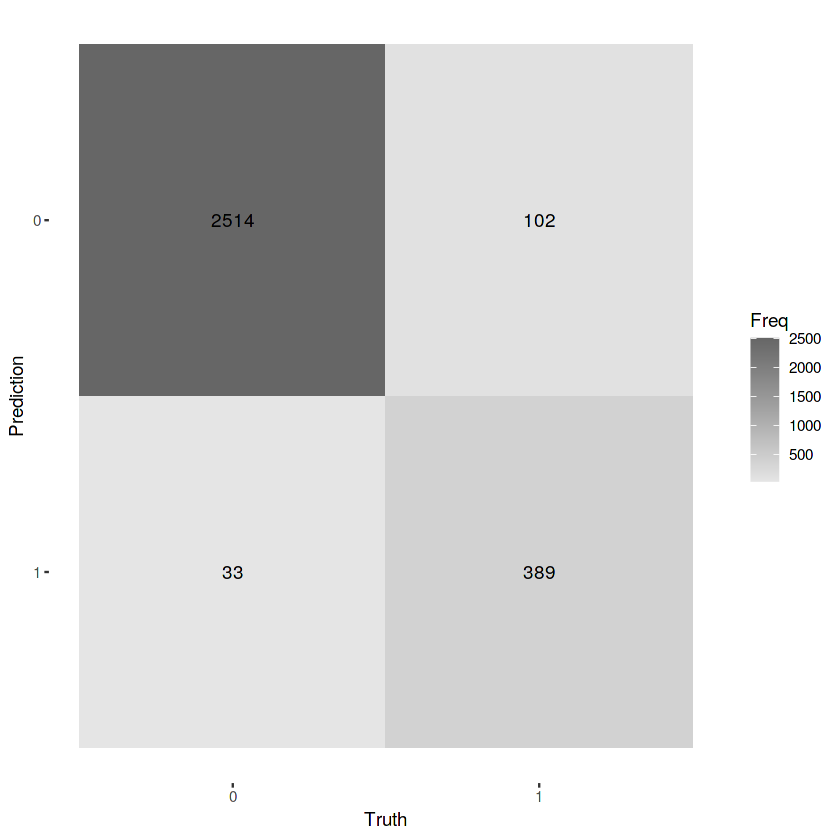

In [15]:
rf_model = randomForest(Attrition_Flag ~ ., data = trainData)
rf_prediction = predict(rf_model, testData)
report(rf_prediction, test_Y, 'Random Forest')
prediction_matrix['RF'] = rf_prediction

## LDA

Delete column: 28 
[1] "LDA"
       actual
predict    0    1
      0 2421  185
      1  126  306
Accuracy:  0.89763 F1 Score:  0.6630553 
Sensitivity:  0.6232179 Specifity:  0.95053 


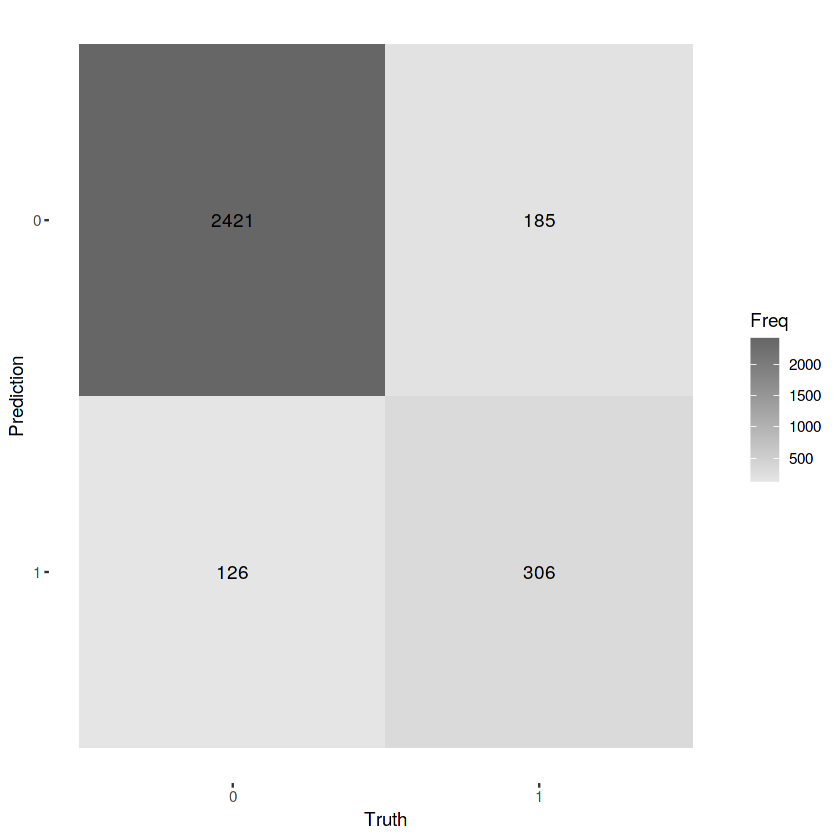

In [16]:
correlation_matrix = cor(trainData[,-1])
hc = findCorrelation(correlation_matrix, cutoff=0.9) #返回correlation大於0.9的variables的index
hc = sort(hc)
cat("Delete column:", hc+1,"\n")
reduced_data = trainData[,-(hc+1)] ##刪去
lda.fit = lda(Attrition_Flag ~ ., data = reduced_data)
lda_prediction = predict(lda.fit, testData)$class
report(lda_prediction, test_Y, 'LDA')
prediction_matrix['LDA'] = lda_prediction

## QDA

[1] "QDA"
       actual
predict    0    1
      0 2392  161
      1  155  330
Accuracy:  0.8959842 F1 Score:  0.6762295 
Sensitivity:  0.6720978 Specifity:  0.9391441 


Warning message in `[<-.data.frame`(`*tmp*`, "QDA", value = list(class = structure(c(1L, :
“provided 2 variables to replace 1 variables”


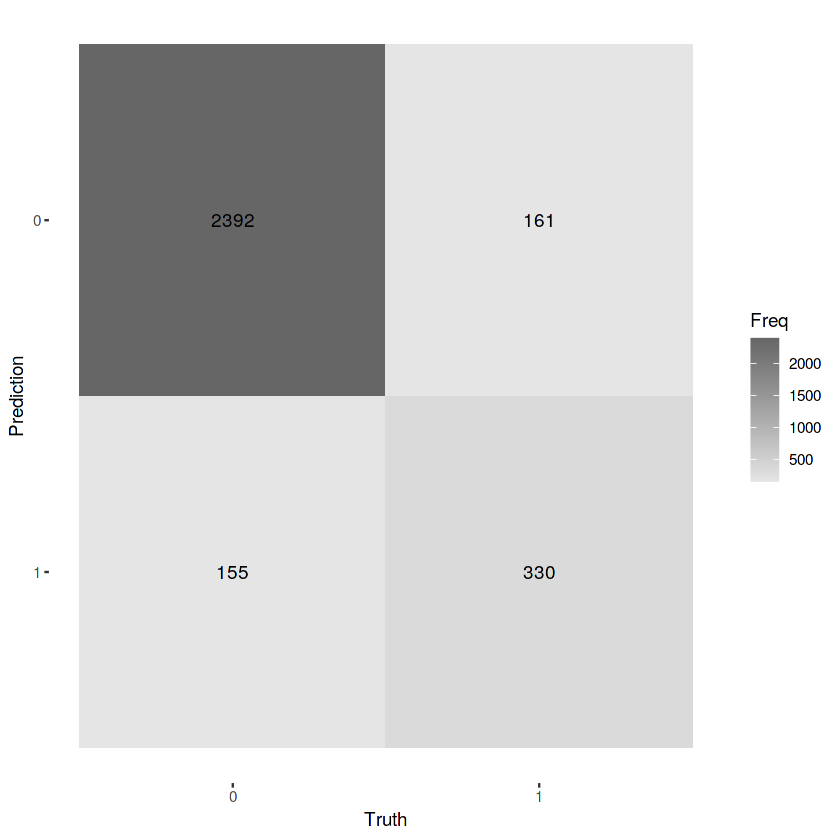

In [17]:
qda.fit = qda(Attrition_Flag ~ ., data = reduced_data)
qda_predication = predict(qda.fit, testData)
report(qda_predication$class, test_Y, 'QDA')
prediction_matrix['QDA'] = qda_predication

## SVM Linear

[1] "SVM Linear"
       actual
predict    0    1
      0 2438  203
      1  109  288
Accuracy:  0.8973009 F1 Score:  0.6486486 
Sensitivity:  0.586558 Specifity:  0.9572046 


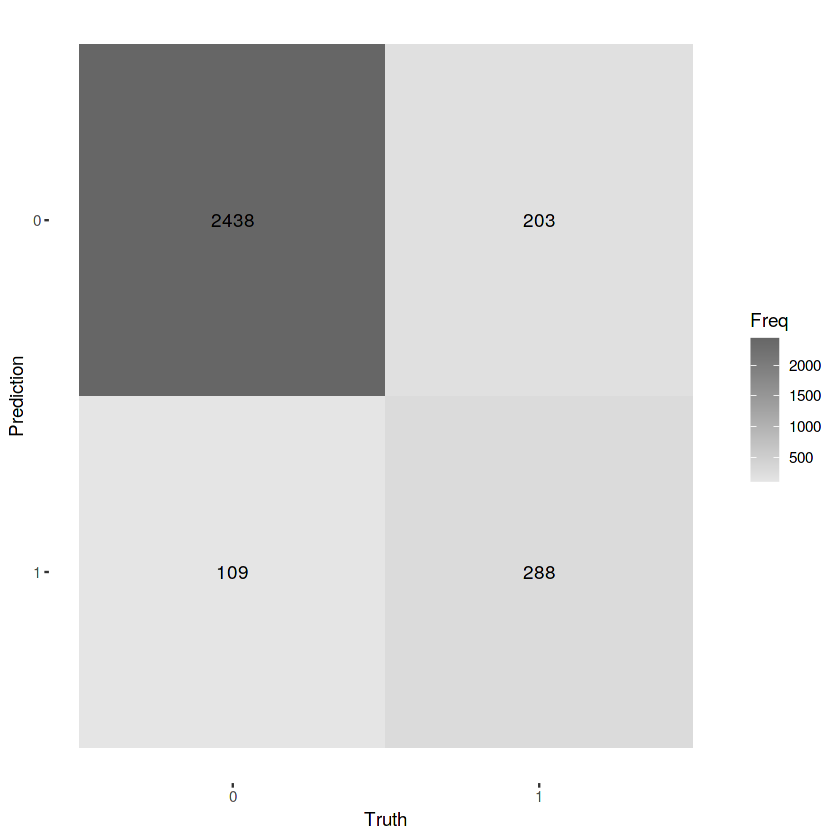

In [18]:
svmL.fit = svm(Attrition_Flag ~ ., data = trainData, kernel = "linear")
svmL_predication = predict(svmL.fit, testData)
report(svmL_predication, test_Y, 'SVM Linear')
prediction_matrix['SVML'] = svmL_predication

## SVM Nonlinear

[1] "SVM nonLinear"
       actual
predict    0    1
      0 2480  195
      1   67  296
Accuracy:  0.9137591 F1 Score:  0.6932084 
Sensitivity:  0.6028513 Specifity:  0.9736945 


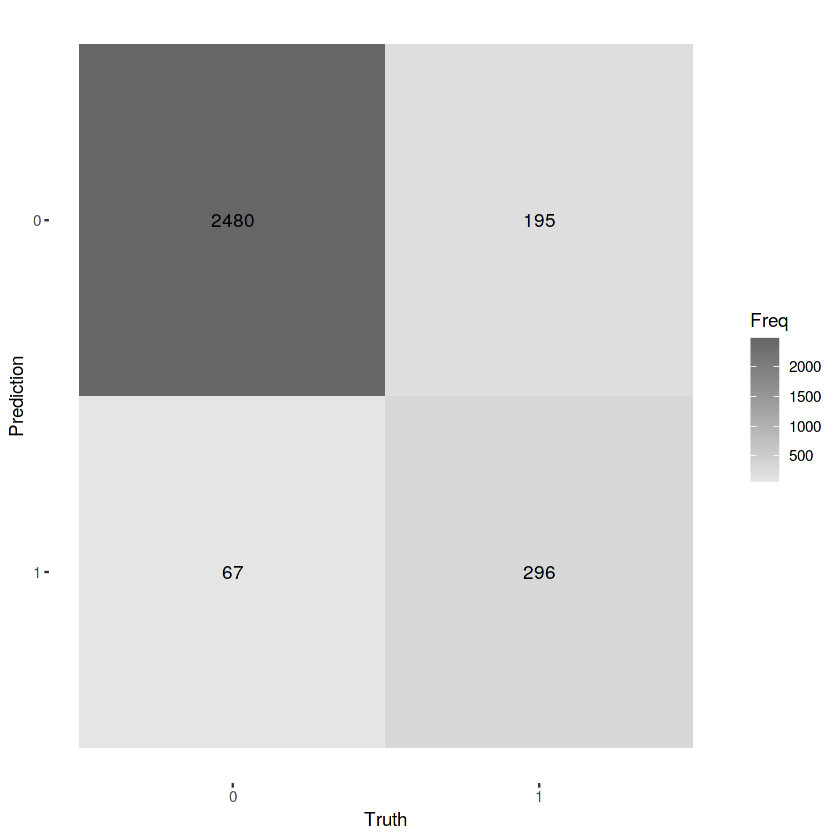

In [19]:
svmNL.fit = svm(Attrition_Flag ~ ., data = trainData, kernel = "radia")
svmNL_predication = predict(svmNL.fit, testData)
report(svmNL_predication, test_Y, 'SVM nonLinear')
prediction_matrix['SVMNL'] = svmNL_predication

## XGBoost

[1] "XGboost"
       actual
predict    0    1
      0 2513   70
      1   34  421
Accuracy:  0.965767 F1 Score:  0.8900634 
Sensitivity:  0.8574338 Specifity:  0.986651 


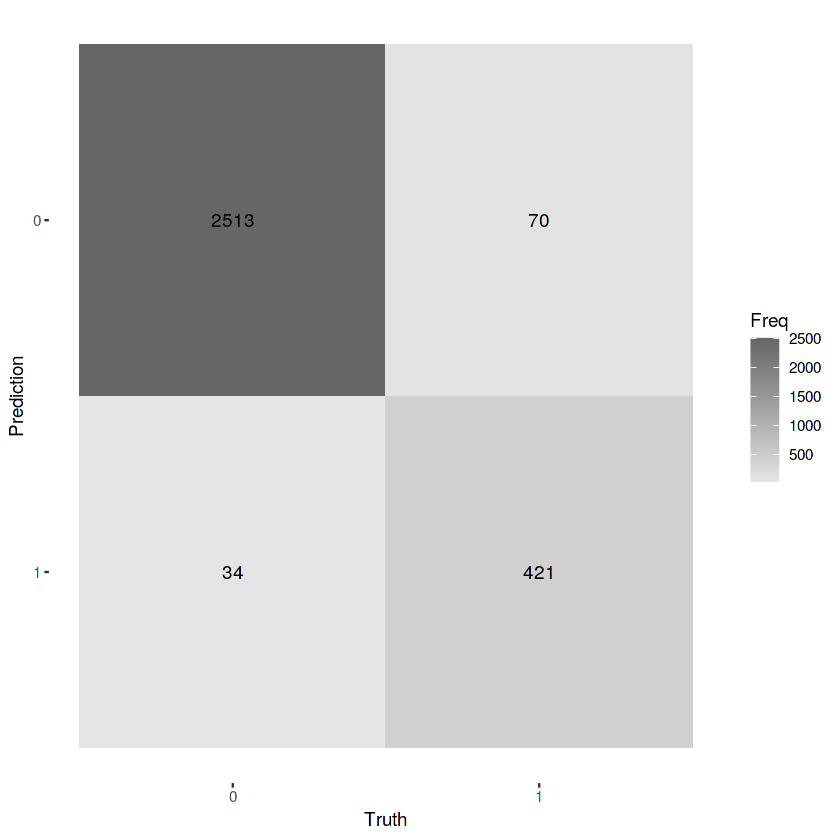

In [20]:
train_Y.int = as.integer(levels(train_Y))[train_Y]
xgb.fit = xgboost(data = train_X, label = train_Y.int, nrounds = 25, params = list(objective="multi:softmax", num_class = 2), verbose = 0)
xgb_prediction = predict(xgb.fit, newdata = test_X)
report(xgb_prediction, test_Y, 'XGboost')
prediction_matrix['XGBoost'] = xgb_prediction

## Boosting

[1] "gbm.fit"
       actual
predict    0    1
      0 2508   69
      1   39  422
Accuracy:  0.9644503 F1 Score:  0.8865546 
Sensitivity:  0.8594705 Specifity:  0.9846879 


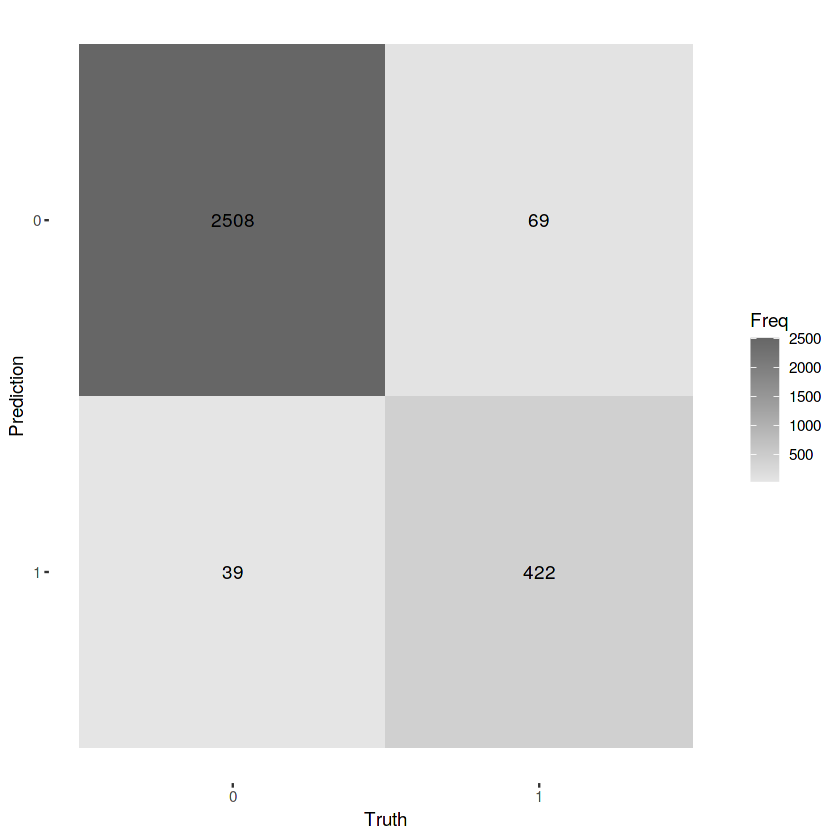

In [21]:
trainData.Y.int = trainData
trainData.Y.int$Attrition_Flag = train_Y.int
gbm.fit = gbm(Attrition_Flag ~ ., data = trainData.Y.int, distribution = "bernoulli", n.trees = 1000)
gbm_prob = predict(gbm.fit, newdata = testData, n.trees = 1000, type = "response")
gbm_prediction = ifelse(gbm_prob > 0.5, 1, 0)
report(gbm_prediction, test_Y, 'gbm.fit')
prediction_matrix['GBM'] = gbm_prediction

## Catboost

Learning rate set to 0.012494
0:	learn: 0.6847046	total: 54.1ms	remaining: 9m 1s
50:	learn: 0.4158185	total: 325ms	remaining: 1m 3s
100:	learn: 0.2948638	total: 616ms	remaining: 1m
150:	learn: 0.2305704	total: 882ms	remaining: 57.5s
200:	learn: 0.1937719	total: 1.14s	remaining: 55.8s
250:	learn: 0.1707875	total: 1.42s	remaining: 55s
300:	learn: 0.1519682	total: 1.69s	remaining: 54.4s
350:	learn: 0.1399695	total: 1.95s	remaining: 53.7s
400:	learn: 0.1297775	total: 2.22s	remaining: 53.2s
450:	learn: 0.1213467	total: 2.5s	remaining: 52.9s
500:	learn: 0.1138210	total: 2.78s	remaining: 52.6s
550:	learn: 0.1078908	total: 3.05s	remaining: 52.3s
600:	learn: 0.1030202	total: 3.34s	remaining: 52.2s
650:	learn: 0.0990092	total: 3.62s	remaining: 52s
700:	learn: 0.0951975	total: 3.89s	remaining: 51.6s
750:	learn: 0.0914987	total: 4.16s	remaining: 51.2s
800:	learn: 0.0882561	total: 4.44s	remaining: 51s
850:	learn: 0.0852393	total: 4.7s	remaining: 50.6s
900:	learn: 0.0823760	total: 4.99s	remaining: 5

[1] "Catboost"
       actual
predict    0    1
      0 2522   52
      1   25  439
Accuracy:  0.9746544 F1 Score:  0.9193717 
Sensitivity:  0.8940937 Specifity:  0.9901845 


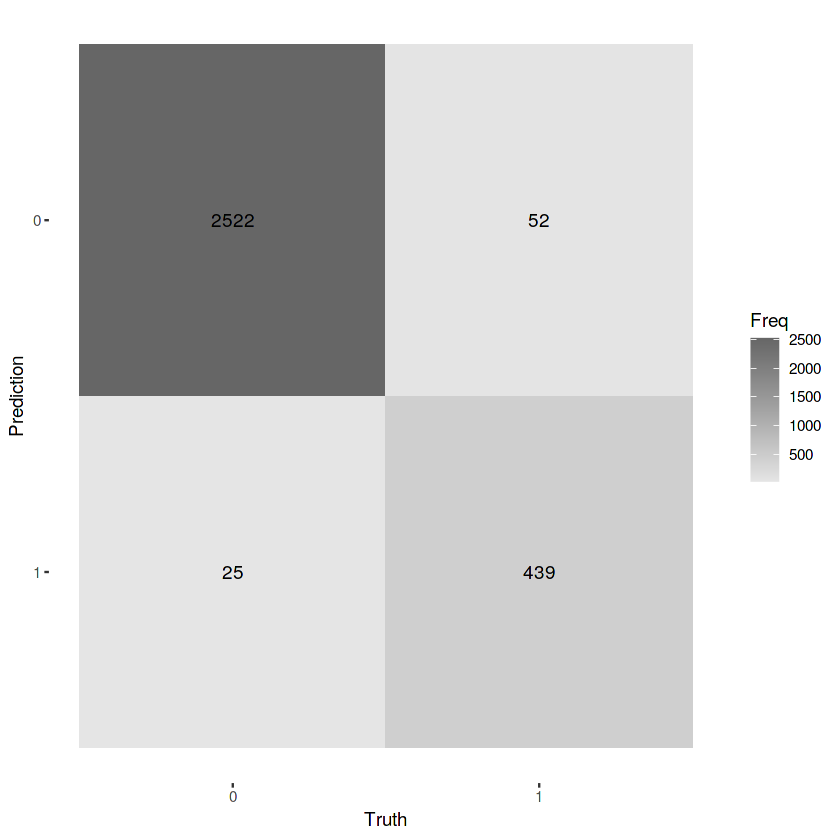

In [22]:
train_pool = catboost.load_pool(data = train_X, label = as.integer(train_Y))
CB_model = catboost.train(train_pool,
                        params = list(loss_function = 'MultiClass',
                                      iterations = 10000, metric_period=50, thread_count = 4))
test_pool =  catboost.load_pool(data = test_X, label = as.integer(test_Y))
prediction = catboost.predict(CB_model, test_pool, prediction_type = "Probability")
colnames(prediction) = levels(as.factor(c(0,1)))
cat_test_prediction = apply(prediction,1,function(x) colnames(prediction)[which.max(x)])
prediction_matrix['Catboost'] = cat_test_prediction
report(cat_test_prediction, test_Y, "Catboost")

# Stacking

In [23]:
n = 5
n.folds = rep(1:n, each=nrow(trainData)/n)
n.folds = c(n.folds, 5, 5, 5, 5)
layer1_train = as.data.frame(train_Y)
layer1_test = as.data.frame(test_Y)

## First Level - Logistic Regression

In [24]:
lr_train = c()
lr_test = matrix(0, nrow = nrow(test_X), ncol = n)
for(i in 1:5){
    train_X = model.matrix(Attrition_Flag ~., data = trainData[which(n.folds != i), ])[, -1]
    train_Y = trainData[which(n.folds != i), ]$Attrition_Flag
    train_X_rest = model.matrix(Attrition_Flag ~., data = trainData[which(n.folds == i), ])[, -1]
    LASSO.cv.fit = cv.glmnet(
    x = train_X,
    y = train_Y,
    alpha = 1, 
    nfolds = 10,
    family = "binomial"
    )
    train_prediction = as.integer(predict(LASSO.cv.fit, s = "lambda.min", newx = train_X_rest, type = 'class'))
    lr_train = c(lr_train, train_prediction)
    lr_test[,i] = as.integer(predict(LASSO.cv.fit, s = "lambda.min", newx = test_X, type = 'class'))
}
layer1_test['lr'] = vote(lr_test, c(1,1,1,1,1))
layer1_train['lr'] = lr_train

## First Level - Decision Tree

In [25]:
dt_train = c()
dt_test = matrix(0, nrow = nrow(test_X), ncol = n)
for(i in 1:5){   
    dt_model = rpart(Attrition_Flag ~ .,data = trainData[which(n.folds != i), ], method = "class")

    train_prediction = as.integer(predict(dt_model,trainData[which(n.folds == i), ], type = 'class'))-1
    dt_train = c(dt_train, train_prediction)
    dt_test[,i] = as.integer(predict(dt_model, testData, type = 'class'))-1
}
layer1_test['dt'] = vote(dt_test, c(1,1,1,1,1))
layer1_train['dt'] = dt_train

## First Level - Random Forest

In [26]:
rf_train = c()
rf_test = matrix(0, nrow = nrow(test_X), ncol = n)
for(i in 1:5){   
  rf_model = randomForest(Attrition_Flag ~ ., data = trainData[which(n.folds != i), ])
  
  train_prediction = as.integer(predict(rf_model, trainData[which(n.folds == i), ]))-1
  rf_train = c(rf_train, train_prediction)
  rf_test[,i] = as.integer(predict(rf_model, testData))-1
}
layer1_test['rf'] = vote(rf_test, c(1,1,1,1,1))
layer1_train['rf'] = rf_train

## First Level - LDA

In [27]:
LDA_train = c()
LDA_test = matrix(0, nrow = nrow(test_X), ncol = n)
for(i in 1:5){   
  LDA_model = lda(Attrition_Flag ~ ., data = trainData[which(n.folds != i), ])
  train_prediction = as.integer(predict(LDA_model, trainData[which(n.folds == i), ])$class)-1
  LDA_train = c(LDA_train, train_prediction)
  LDA_test[,i] = as.integer(predict(LDA_model, testData)$class)-1
}
layer1_test['LDA'] = vote(LDA_test, c(1,1,1,1,1))
layer1_train['LDA'] = LDA_train

Warning message in lda.default(x, grouping, ...):
“variables are collinear”
Warning message in lda.default(x, grouping, ...):
“variables are collinear”
Warning message in lda.default(x, grouping, ...):
“variables are collinear”
Warning message in lda.default(x, grouping, ...):
“variables are collinear”
Warning message in lda.default(x, grouping, ...):
“variables are collinear”


## First Level - QDA (Unable to function again)

In [28]:
# QDA_train = c()
# QDA_test = matrix(0, nrow = nrow(test_X), ncol = n)
# for(i in 1:5){
#   reduced_data = trainData[which(n.folds != i), ][,-(hc+1)]
#   QDA_model = qda(Attrition_Flag ~ ., data = trainData[which(n.folds != i), ][,-28])
#   train_prediction = as.integer(predict(QDA_model,trainData[which(n.folds == i), ])$class)-1
#   QDA_train = c(QDA_train, train_prediction)
#   QDA_test[,i] = as.integer(predict(QDA_model, testData)$class)-1
# }
# layer1_test['QDA'] = vote(QDA_test, c(1,1,1,1,1))
# layer1_train['QDA'] = QDA_train

## First Level - SVM Linear

In [29]:
SVML_train = c()
SVML_test = matrix(0, nrow = nrow(test_X), ncol = n)
for(i in 1:5){   
  SVML_model = svm(Attrition_Flag ~ ., data = trainData[which(n.folds != i), ], kernel = "linear")
  train_prediction = as.integer(predict(SVML_model, trainData[which(n.folds == i), ]))-1
  SVML_train = c(SVML_train, train_prediction)
  SVML_test[,i] = as.integer(predict(SVML_model, testData))-1
}
layer1_test['SVML'] = vote(SVML_test, c(1,1,1,1,1))
layer1_train['SVML'] = SVML_train

## First Level - SVM Non-linear

In [30]:
SVMNL_train = c()
SVMNL_test = matrix(0, nrow = nrow(test_X), ncol = n)
for(i in 1:5){   
  SVMNL_model = svm(Attrition_Flag ~ ., data = trainData[which(n.folds != i), ], kernel = "radia")
  train_prediction = as.integer(predict(SVMNL_model, trainData[which(n.folds == i), ]))-1
  SVMNL_train = c(SVMNL_train, train_prediction)
  SVMNL_test[,i] = as.integer(predict(SVMNL_model, testData))-1
}
layer1_test['SVMNL'] = vote(SVMNL_test, c(1,1,1,1,1))
layer1_train['SVMNL'] = SVMNL_train

## First Level - XGboost

In [31]:
xgb_train = c()
xgb_test = matrix(0, nrow = nrow(test_X), ncol = n)
for(i in 1:5){
  train_X = model.matrix(Attrition_Flag ~., data = trainData[which(n.folds != i), ])[, -1]
  train_Y = trainData[which(n.folds != i), ]$Attrition_Flag
  train_X_rest = model.matrix(Attrition_Flag ~., data = trainData[which(n.folds == i), ])[, -1]
  train_Y.int = as.integer(levels(train_Y))[train_Y]
    
  xgb_model = xgboost(data = train_X, label = train_Y.int, nrounds = 25, params = list(objective="multi:softmax", num_class = 2), verbose = 0)
  
  train_prediction = as.integer(predict(xgb_model, newdata = train_X_rest))
  xgb_train = c(xgb_train, train_prediction)
  xgb_test[,i] = as.integer(predict(xgb_model, newdata = test_X))
}
layer1_test['xgb'] = vote(xgb_test, c(1,1,1,1,1))
layer1_train['xgb'] = xgb_train

## First Level - Boosting

In [32]:
gbm_train = c()
gbm_test = matrix(0, nrow = nrow(test_X), ncol = n)
for(i in 1:5){
  trainData.Y.int = trainData[which(n.folds != i), ]
  train_Y = trainData[which(n.folds != i), ]$Attrition_Flag
  train_Y.int = as.integer(levels(train_Y))[train_Y]
    
  trainData.Y.int$Attrition_Flag = train_Y.int
  gbm_model = gbm(Attrition_Flag ~ ., data = trainData.Y.int, distribution = "bernoulli", n.trees = 1000)
    
  gbm_prob = predict(gbm_model, newdata = trainData[which(n.folds == i), ], n.trees = 1000, type = "response")    
  train_prediction = ifelse(gbm_prob > 0.5, 1, 0)    
  gbm_train = c(gbm_train, train_prediction)
    
  gbm_prob = predict(gbm_model, newdata = testData, n.trees = 1000, type = "response")       
  gbm_test[,i] = ifelse(gbm_prob > 0.5, 1, 0)
}
layer1_test['gbm'] = vote(gbm_test, c(1,1,1,1,1))
layer1_train['gbm'] = gbm_train

## First Level - CatBoost

In [33]:
catb_train = c()
catb_test = matrix(0, nrow = nrow(test_X), ncol = n)
for(i in 1:5){
    train_X = model.matrix(Attrition_Flag ~., data = trainData[which(n.folds != i), ])[, -1]
    train_Y = trainData[which(n.folds != i), ]$Attrition_Flag
    train_X_rest = model.matrix(Attrition_Flag ~., data = trainData[which(n.folds == i), ])[, -1]
    train_Y.int = as.integer(levels(train_Y))[train_Y]
    train_X_pool = catboost.load_pool(data = train_X, label = as.integer(train_Y))
    train_X_rest_pool = catboost.load_pool(data = train_X_rest)
    
    CB_model = catboost.train(train_X_pool,
                              params = list(loss_function = 'MultiClass', 
                                              iterations = 4000, 
                                              metric_period = 50, 
                                              thread_count = 2))
    
    test_pool =  catboost.load_pool(data = test_X)
    train_probability = catboost.predict(
        CB_model, train_X_rest_pool, prediction_type = "Probability")[, 2]
    train_prediction = ifelse(train_probability > 0.5, 1, 0)
    catb_train = c(catb_train, train_prediction)
    test_probability = catboost.predict(
        CB_model, test_pool, prediction_type = "Probability")[, 2]
    catb_test[,i] = ifelse(test_probability > 0.5, 1, 0)
}
layer1_test['catb'] = vote(catb_test, c(1,1,1,1,1))
layer1_train['catb'] = catb_train

Learning rate set to 0.026793
0:	learn: 0.6746689	total: 5.54ms	remaining: 22.2s
50:	learn: 0.2871363	total: 242ms	remaining: 18.7s
100:	learn: 0.1862916	total: 469ms	remaining: 18.1s
150:	learn: 0.1462257	total: 696ms	remaining: 17.7s
200:	learn: 0.1244097	total: 925ms	remaining: 17.5s
250:	learn: 0.1095062	total: 1.16s	remaining: 17.3s
300:	learn: 0.0984289	total: 1.39s	remaining: 17.1s
350:	learn: 0.0902878	total: 1.61s	remaining: 16.8s
400:	learn: 0.0834215	total: 1.84s	remaining: 16.5s
450:	learn: 0.0778411	total: 2.07s	remaining: 16.3s
500:	learn: 0.0729096	total: 2.3s	remaining: 16s
550:	learn: 0.0689538	total: 2.52s	remaining: 15.8s
600:	learn: 0.0653332	total: 2.75s	remaining: 15.5s
650:	learn: 0.0621550	total: 2.97s	remaining: 15.3s
700:	learn: 0.0593078	total: 3.2s	remaining: 15.1s
750:	learn: 0.0568398	total: 3.43s	remaining: 14.8s
800:	learn: 0.0542932	total: 3.65s	remaining: 14.6s
850:	learn: 0.0523552	total: 3.88s	remaining: 14.4s
900:	learn: 0.0503439	total: 4.11s	remai

In [34]:
head(layer1_train)

,train_Y,lr,dt,rf,LDA,SVML,SVMNL,xgb,gbm,catb
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,1,0,1,1,0,0,1,1,1,1
6,0,0,0,0,0,0,0,0,0,0


In [35]:
for(i in 2:10){
    print(accuracy(layer1_test[,1],layer1_test[,i]))
}

[1] 0.8966425
[1] 0.9285714
[1] 0.9542462
[1] 0.89763
[1] 0.8989467
[1] 0.9140882
[1] 0.9693878
[1] 0.9624753
[1] 0.9749835


## Second Level - XGBoost

In [36]:
colnames(layer1_train)[1] = "Y"
colnames(layer1_test)[1] = "Y"

In [37]:
train_data = cbind(layer1_train, trainData[,-1])
test_data = cbind(layer1_test, testData[,-1])

In [123]:
train_X_2 = model.matrix(Y~., train_data)[,-1]
train_Y_2 = layer1_train$Y
test_X_2 = model.matrix(Y~., test_data)[,-1]
test_Y_2 = layer1_test$Y

[15:35:31] WARNING: amalgamation/../src/learner.cc:516: 
Parameters: { early_stopping_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[1] "XGboost"
       actual
predict    0    1
      0 2518   47
      1   29  444
Accuracy:  0.9749835 F1 Score:  0.9211618 
Sensitivity:  0.904277 Specifity:  0.9886141 


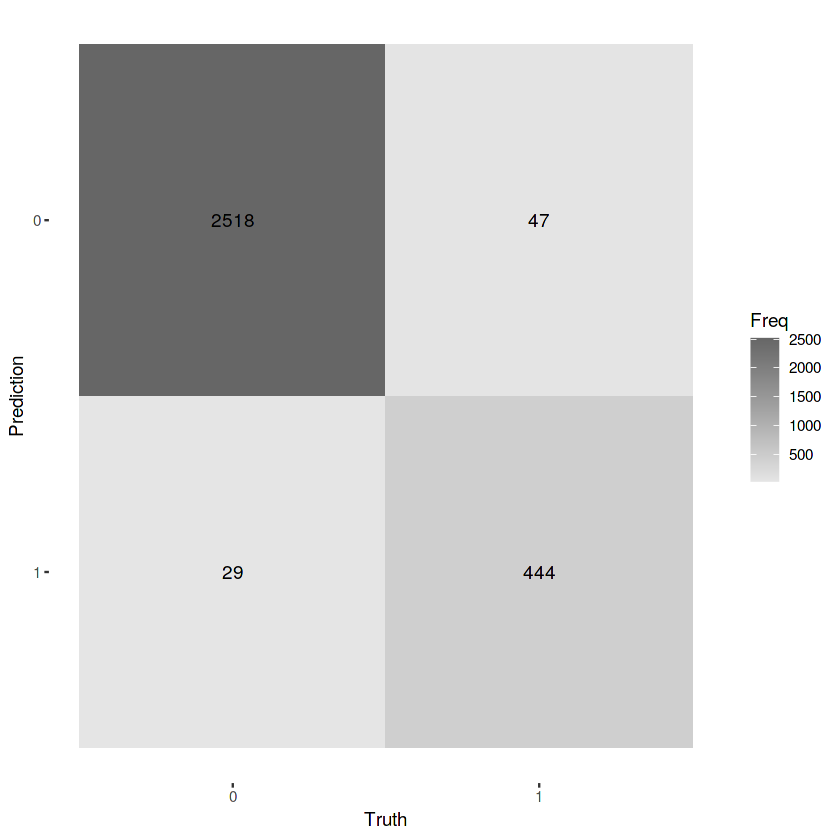

In [142]:
train_Y_2.int = as.integer(levels(train_Y_2))[train_Y_2]
xgb_2.fit = xgboost(data = train_X_2, label = train_Y_2.int, nrounds = 50, params = list(objective="multi:softmax", num_class = 2), verbose = 0, early.stopping.round = 3)
xgb_prediction_2 = predict(xgb_2.fit, newdata = test_X_2)
report(xgb_prediction_2, test_Y_2, 'XGboost')